# Imports

In [225]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly
import plotly.graph_objs as go
import wandb

from ocean_navigation_simulator.utils.misc import get_c3



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preparation

### Get c3 object/hook

In [3]:
c3 = get_c3()

Starting to connect to c3


### Get Experiment

In [430]:
experiment_name="HC_umax_0.5_30"
exp = c3.Experiment.get(experiment_name)

In [431]:
exp

c3.Experiment(
 id='HC_umax_0.5_30',
 meta=c3.Meta(
        tenantTagId=32,
        tenant='seaweed-control',
        tag='devseaweedrc1',
        created=datetime.datetime(2023, 2, 3, 7, 58, 42, tzinfo=datetime.timezone.utc),
        createdBy='killer@berkeley.edu',
        updated=datetime.datetime(2023, 2, 3, 7, 58, 42, tzinfo=datetime.timezone.utc),
        updatedBy='killer@berkeley.edu',
        timestamp=datetime.datetime(2023, 2, 3, 7, 58, 42, tzinfo=datetime.timezone.utc),
        fetchInclude='[]',
        fetchType='Experiment'),
 version=1,
 experimentName='HC_umax_0.5_30',
 description='HC_umax_0.5_30',
 arenaConfig={'casadi_cache_dict': {'deg_around_x_t': 2.0,
                                     'time_around_x_t': 432000},
               'ocean_dict': {'forecast': None,
                              'hindcast': {'field': 'OceanCurrents',
                                           'source': 'hindcast_files',
                                           'source_settings': {'

### Fetch all related OceanSimRuns

Get all Missions

In [432]:
all_Missions = exp.get('expMissions').expMissions

In [433]:
len(all_Missions)

1000

Get all Controller

In [434]:
all_Controllers = exp.get('controllers').controllers
ctrl_names = [ctrl.id[15:] for ctrl in all_Controllers]


In [435]:
ctrl_names

['SeaweedHJController']

Get all OceanSimRuns

In [436]:
# get all OceanSimRuns for each Controller
OceanSimObj_lists = []
# get the objects from the database
for ctrl in all_Controllers:
    # get the objects from the table
    controller = 'controllerSetting==' + '"' + ctrl.id + '"'
    status = ' && status ==' + '"' + 'finished_running' + '"'
    #termination_reason = ' && terminationReason ==' + '"' + 'Timeout' + '"'
    OceanSimObj_lists.append(c3.OceanSimRun.fetch(spec={'include': "[this]",
                                         'filter': controller + status,
                                         'order': "ascending(mission.id)"
                                                       }
                                   ).objs)

In [437]:
len(OceanSimObj_lists[0])

996

## Initialize WandB

In [450]:
wandb.join()

In [343]:
oceanSim = OceanSimObj_lists[0][0]
### Prepare data for WandB
ctrlConfig = oceanSim.controllerSetting.get("ctrlConfig").ctrlConfig
observerConfig = oceanSim.observerSetting.get("observerConfig").observerConfig

# Prepare variables for run naming

# Planning horizon in days
T_in_days = ctrlConfig["T_goal_in_seconds"] / (24 * 3600)

# Prepare string whether we use only HC or FC/HC
if exp.arenaConfig["ocean_dict"]["forecast"] is not None:
    data_sources = "FC_HC"
else:
    data_sources = "HC"

if (
    ctrlConfig["ctrl_name"]
    == "ocean_navigation_simulator.controllers.hj_planners.HJBSeaweed2DPlanner.HJBSeaweed2DPlanner"
):
    ctrl_name = "HJ"
else:
    ctrl_name = "undefined"

umax = exp.arenaConfig["platform_dict"]["u_max_in_mps"]
deg_around_xt_xT_box_global = ctrlConfig["deg_around_xt_xT_box_global"]
deg_around_xt_xT_box = ctrlConfig["deg_around_xt_xT_box"]
grid_res_global = ctrlConfig["grid_res_global"]
grid_res = ctrlConfig["grid_res"]

### For single expermiment

In [203]:
# Log metrics in WandB
os.environ["WANDB_API_KEY"] = "4c142c345dfc64f3c73aa1b2834989c7eb91efbe"

wandb.init(
    # Set the project where this run will be logged
    project="Long Horizon Seaweed Maximization",
    entity="matthiaskiller",
    id=exp.id,
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"Exp_summary_{exp.id}_{ctrl_name}_{data_sources}_days_{T_in_days}_u_{umax}_deg_{deg_around_xt_xT_box_global}_{deg_around_xt_xT_box}_res_{grid_res_global}_{grid_res}",
    # Track hyperparameters and run metadata
    config={
        "summary_log": "single_exp",
        "arenaConfig": exp.arenaConfig,
        "ctrlConfig": ctrlConfig,
        "observerConfig": observerConfig,
        "experiment.id": exp.id,
        # "path_to_local_data": user_param["metrics_dir"],
    },
)

### Summarizing multiple runs

In [344]:
# Log metrics in WandB
os.environ["WANDB_API_KEY"] = "4c142c345dfc64f3c73aa1b2834989c7eb91efbe"

wandb.init(
    # Set the project where this run will be logged
    project="Long Horizon Seaweed Maximization",
    entity="matthiaskiller",
    id="Summary_seaweed_vs_umax_30_days_15deg_below_equator",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"Summary_seaweed_vs_umax_{ctrl_name}_{data_sources}_days_{T_in_days}_deg_{deg_around_xt_xT_box_global}_{deg_around_xt_xT_box}_res_{grid_res_global}_{grid_res}",
    # Track hyperparameters and run metadata
    config={
        "summary_log": "multiple_exp",
        #"arenaConfig": exp.arenaConfig,
        "ctrlConfig": ctrlConfig,
        "observerConfig": observerConfig,
        #"experiment.id": exp.id,
        # "path_to_local_data": user_param["metrics_dir"],
    },
)

# Pre-processing

## Get maximum travel area

In [204]:
def get_maximum_dist(x_start, lon_list, lat_list):
    max_lon = max([abs(x_start[0]-lon_list[0]),abs(x_start[0]-lon_list[1])])
    max_lat = max([abs(x_start[1]-lat_list[0]),abs(x_start[1]-lat_list[1])])
    return max_lon, max_lat

In [205]:
max_lon = 0
max_lat = 0
max_lon_id = None
max_lat_id = None
missions_over_ctrl_deg_max = []

for run in OceanSimObj_lists[0]:
    try:
        trajectory = c3.HycomUtil.get_traj_dict(run, local_folder="tmp/test")["sim_traj"]
        lon_list = [min(trajectory[:, 0]),max(trajectory[:, 0])]
        lat_list = [min(trajectory[:, 1]),max(trajectory[:, 1])]
        x_start = trajectory[0, :2]
        curr_max_lon, curr_max_lat = get_maximum_dist(x_start, lon_list, lat_list)
        
        if max_lon < curr_max_lon:
            max_lon = curr_max_lon
            max_lon_id = run.mission.id

        if max_lat < curr_max_lat:
            max_lat = curr_max_lat
            max_lat_id = run.mission.id
        
        if curr_max_lon > ctrlConfig["deg_around_xt_xT_box_global"] or curr_max_lat > ctrlConfig["deg_around_xt_xT_box_global"]:
            missions_over_ctrl_deg_max.append(run.mission.id)
        
    except:
        print("download error")

In [206]:
print(max_lon)
print(max_lat)
print(max_lon_id)
print(max_lat_id)
print(len(missions_over_ctrl_deg_max))


21.523308932071757
9.125072382176711
HC_umax_0.0_30_batch_seed_151_24
HC_umax_0.0_30_batch_seed_158_10
5


In [207]:
missions_over_ctrl_deg_max

['HC_umax_0.0_30_batch_seed_123_19',
 'HC_umax_0.0_30_batch_seed_130_12',
 'HC_umax_0.0_30_batch_seed_148_11',
 'HC_umax_0.0_30_batch_seed_151_24',
 'HC_umax_0.0_30_batch_seed_153_20']

Log to W&B

In [208]:
wandb.summary["max_degree_lon"]=max_lon
wandb.summary["max_degree_lat"]=max_lat
wandb.summary["max_degree_lon_mission_id"]=max_lon_id
wandb.summary["max_degree_lat_mission_id"]=max_lat_id
wandb.summary["missions_over_ctrl_deg_max"]=missions_over_ctrl_deg_max

## Get all w/o stranded

Get the last entry of the seaweed trajectory over all OceanSimRuns which didn't strand etc.

In [209]:
# get all OceanSimRuns for each Controller
OceanSimObj_lists_filtered = []
# get the objects from the database
for ctrl in all_Controllers:
    # get the objects from the table
    controller = 'controllerSetting==' + '"' + ctrl.id + '"'
    status = ' && status ==' + '"' + 'finished_running' + '"'
    termination_reason = ' && terminationReason ==' + '"' + 'Timeout' + '"'
    OceanSimObj_lists_filtered.append(c3.OceanSimRun.fetch(spec={'include': "[this]",
                                         'filter': controller + status + termination_reason,
                                         'order': "ascending(mission.id)"
                                                       }
                                   ).objs)

In [210]:
len(OceanSimObj_lists_filtered[0])

856

In [211]:
final_seaweed_list = []
for run in OceanSimObj_lists_filtered[0]:
    try:
        trajectory = c3.HycomUtil.get_traj_dict(run, local_folder="tmp/test")["sim_traj"]
        final_seaweed_list.append(trajectory[-1, 4])
    except:
        print("download error")

In [212]:
len(final_seaweed_list)

856

In [213]:
average_seaweed_end = np.mean(final_seaweed_list)

In [16]:
# final_seaweed_dict={
#     "0.0": final_seaweed_list
# }

In [110]:
final_seaweed_dict["0.5"]=final_seaweed_list

In [141]:
for key,l in final_seaweed_dict.items():
    print(len(l))

856
791
758
742
723
712


In [142]:
for key,l in final_seaweed_dict.items():
    print(np.mean(l))

82.79386040352566
98.19124514951237
112.81893668984839
123.44466993899725
131.92189745365357
139.84294974869533


## Get depending on start position and w/o stranded

In [438]:
# get all OceanSimRuns for each Controller
OceanSimObj_lists_filtered = []
# get the objects from the database
for ctrl in all_Controllers:
    # get the objects from the table
    controller = 'controllerSetting==' + '"' + ctrl.id + '"'
    status = ' && status ==' + '"' + 'finished_running' + '"'
    termination_reason = ' && terminationReason ==' + '"' + 'Timeout' + '"'
    OceanSimObj_lists_filtered.append(c3.OceanSimRun.fetch(spec={'include': "[this]",
                                         'filter': controller + status + termination_reason,
                                         'order': "ascending(mission.id)"
                                                       }
                                   ).objs)

In [439]:
len(OceanSimObj_lists_filtered[0])

712

In [440]:
OceanSimObj_lists_filtered_by_coords = []

for run in OceanSimObj_lists_filtered[0]:
    if run.mission.get("missionConfig").missionConfig["x_0"][0]["lat"] < 0:
        OceanSimObj_lists_filtered_by_coords.append(run) 

In [441]:
len(OceanSimObj_lists_filtered_by_coords)

458

In [442]:
final_seaweed_list = []
for run in OceanSimObj_lists_filtered_by_coords:
    try:
        trajectory = c3.HycomUtil.get_traj_dict(run, local_folder="tmp/test")["sim_traj"]
        final_seaweed_list.append(trajectory[-1, 4])
    except:
        print("download error")

In [443]:
len(final_seaweed_list)

458

In [351]:
# final_seaweed_dict={
#     "0.0": final_seaweed_list
# }

In [444]:
final_seaweed_dict["0.5"]=final_seaweed_list

In [445]:
for key,l in final_seaweed_dict.items():
    print(len(l))

469
489
498
489
473
458


In [446]:
for key,l in final_seaweed_dict.items():
    print(np.mean(l))

103.43513286645249
117.89005076450948
129.48094820521334
138.38188122609372
144.33082988853127
150.19306730120613


# Plotting

### Matplotlib

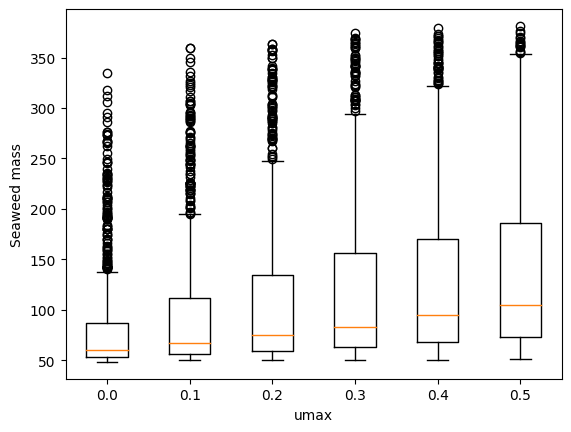

In [163]:
# Create a box plot of the values in the dictionary
plt.boxplot([final_seaweed_dict[key] for key in final_seaweed_dict.keys()], labels=final_seaweed_dict.keys())

# Calculate the mean of each item in the dictionary
mean = [np.mean(final_seaweed_dict[key]) for key in final_seaweed_dict.keys()]

## Add a scatter plot for the mean
# plt.scatter(x=list(final_seaweed_dict.keys()), y=mean, color='red')


# Label the y-axis
plt.ylabel('Seaweed mass')
plt.xlabel('umax')

# Show the plot
plt.show()

### Plotly

In [448]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(final_seaweed_dict, orient='index').transpose()

# Create a box plot in Plotly
fig = px.box(df)

fig.update_layout(xaxis_title="u_max", yaxis_title="Seaweed mass", title="Seaweed mass vs u_max")


mean_trace = go.Scatter(
    x=df.columns,
    y=df.mean(),
    mode='lines',
    line=dict(color='green', width=2),
    showlegend=True,
    name="mean"
)

fig.add_trace(mean_trace)

fig.write_html("seaweed_vs_umax_old.html")

#fig.show()



In [449]:
wandb.log({"seaweed_vs_umax_plotly": fig})

# Summary Logging

## Summarize single experiment and compute results over all its missions

In [214]:
wandb.summary["average_seaweed_mass_end"] = average_seaweed_end

In [215]:
all_Missions = exp.get('expMissions').expMissions

Check if all simulations finshed properly

In [216]:
experiment = 'mission.experiment.id==' + '"' + exp.id + '"'
objs_list = c3.OceanSimRun.fetch(spec={'include': "[this]",'filter':  experiment}).objs
print("Total of {} OceanSimRuns".format(len(objs_list)))

staged_to_run = 0
running_sim = 0
finished_running = 0
run_failed = 0
for run in objs_list:
    if run.status == 'staged_to_run':
        staged_to_run += 1
    elif run.status == 'running_sim':
        running_sim += 1
    elif run.status == 'finished_running':
        finished_running += 1
    elif run.status == 'run_failed':
        run_failed += 1

print("staged_to_run: ", staged_to_run)
print("running_sim: ", running_sim)
print("finished_running: ", finished_running)
print("run_failed: ", run_failed)

Total of 1000 OceanSimRuns
staged_to_run:  0
running_sim:  1
finished_running:  999
run_failed:  0


### Accessing variables on the OceanSimRun level (e.g. status, terminationReason)

In [217]:
import pandas as pd
def get_results_df(this):
    # get all runs from the database (NOTE this can only get 2000 at a time!)
    exp_filter = 'mission.experiment.id==' + '"' + this.get('experimentName').experimentName + '"'
    all_exp_runs = c3.OceanSimRun.fetch(spec={'include': "[this]",
                                              'filter': exp_filter,
                                              'order': "ascending(mission.id)",
                                              'limit': -1
                                             }).objs
    # get a list of all termination reasons
    termination_reason = []
    status = []
    ctrl_obs_name = []
    mission_ids = []

    for run in all_exp_runs:
        # get mission_id
        mission_ids.append(run.get('mission').mission.id)
        # get ctrl_obs setting
        ctrl_obs_name.append(run.get('controllerSetting.name').controllerSetting.name + '__' + run.get('observerSetting.name').observerSetting.name)
        # add outcomes
        termination_reason.append(run.terminationReason)
        status.append(run.status)
        
    # Make a df out of it
    df = pd.DataFrame(list(zip(mission_ids, ctrl_obs_name, status, termination_reason)),
                      columns=['mission_id', 'setting', 'status', 'termination_reason'])
    
    return df

In [218]:
missions_summary_df = get_results_df(exp)

In [219]:
missions_summary_df.head()

,mission_id,setting,status,termination_reason
0,HC_umax_0.0_30_batch_seed_122_0,SeaweedHJController__NoObserver,finished_running,Timeout
1,HC_umax_0.0_30_batch_seed_122_1,SeaweedHJController__NoObserver,finished_running,Outside Arena
2,HC_umax_0.0_30_batch_seed_122_10,SeaweedHJController__NoObserver,finished_running,Timeout
3,HC_umax_0.0_30_batch_seed_122_11,SeaweedHJController__NoObserver,finished_running,Timeout
4,HC_umax_0.0_30_batch_seed_122_12,SeaweedHJController__NoObserver,finished_running,Timeout


In [220]:
missions_summary_table = wandb.Table(dataframe=missions_summary_df)
wandb.log({"Missions Summary": missions_summary_table})

In [221]:
missions_summary_df.groupby('setting').status.value_counts()

setting                          status          
SeaweedHJController__NoObserver  finished_running    999
                                 running_sim           1
Name: status, dtype: int64

In [222]:
termination_dict = missions_summary_df.groupby('setting').termination_reason.value_counts(normalize=True).to_dict()
termination_dict = {key[1]: value for key, value in termination_dict.items()}
termination_df = pd.DataFrame(termination_dict,index=[0])
termination_table = wandb.Table(dataframe=termination_df)
wandb.log({"Termination Summary": termination_table})

In [223]:
status_dict = missions_summary_df.groupby('setting').status.value_counts().to_dict()
status_dict = {key[1]: value for key, value in status_dict.items()}
status_df = pd.DataFrame(status_dict,index=[0])
status_table = wandb.Table(dataframe=status_df)
wandb.log({"Status Summary": status_table})